In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import harmonica as hm
import verde as vd
from pathlib import Path
import itertools
import warnings
from tqdm.auto import tqdm
from utilities import xy_into_grid

In [2]:
ds = xr.load_dataset(Path('processed_data/bedmachine_thwaites.nc'))

grav = pd.read_csv(Path('processed_data/gravity_thwaites.csv'))
grav = grav.loc[::10,:]

FileNotFoundError: [Errno 2] No such file or directory: '/Users/holden/Desktop/Ice Shits/processed_data/bedmachine_thwaites.nc'

# Gravity measurements at different heights

In [1]:
plt.scatter(grav.x/1000, grav.y/1000, c=grav.height, s=1, vmin=0, vmax=2000)
plt.axis('scaled')
plt.title('gravity height')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.colorbar(label='m', extend='max')
plt.show()

NameError: name 'plt' is not defined

# Upward continue the gravity data to constant elevation

* choose a height such that you have data that outside of your inversion domain
* filter the gravity data to be below this height

In [4]:
#### height
height = 1200
grav = grav[grav.height < height]

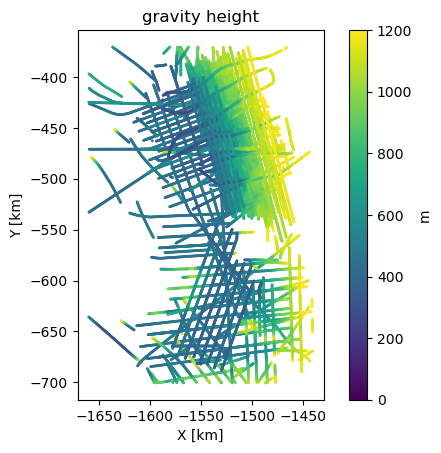

In [5]:
plt.scatter(grav.x/1000, grav.y/1000, c=grav.height, s=1, vmin=0, vmax=1200)
plt.axis('scaled')
plt.title('gravity height')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.colorbar(label='m')
plt.show()

# Now we upward continue to the maximum elevation

* this works by using point sources location below each gravity location
* the masses of the sources are optimized to reproduce the gravity value
* then you can use the point sources to compute the value anywhere above

### We will test out difference combinations of dampings and depths using cross validation

In [6]:
dampings = [0.01, 0.1, 1, 10]
depths = [2e3, 3e3, 4e3]

parameter_sets = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings, depths)
]
print("Number of combinations:", len(parameter_sets))

Number of combinations: 12


In [7]:
%%time

# Gradient Boosted Equivalent sources
equivalent_sources = hm.EquivalentSourcesGB(window_size=20e3)

# Use downsampled data since so dense
coordinates = (grav.x, grav.y, grav.height)

scores = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for params in tqdm(parameter_sets):
        equivalent_sources.set_params(**params)
        score = np.mean(
            vd.cross_val_score(
                equivalent_sources,
                coordinates,
                grav.faa,
            )
        )
        scores.append(score)
scores

  0%|          | 0/12 [00:00<?, ?it/s]

CPU times: total: 30min 9s
Wall time: 2min 47s


[np.float64(0.9954217063945283),
 np.float64(0.9956663756406126),
 np.float64(0.9953031418575413),
 np.float64(0.9963630686758564),
 np.float64(0.9962437514586412),
 np.float64(0.9956376278232261),
 np.float64(0.9964630432803621),
 np.float64(0.9962559530999597),
 np.float64(0.9958377361264648),
 np.float64(0.9961750127773772),
 np.float64(0.9957721294473292),
 np.float64(0.995088299234534)]

# These parameters all score well

We will pull out the best parameters

In [8]:
best = np.argmax(scores)
print("Best score:", scores[best])
print("Best parameters:", parameter_sets[best])

Best score: 0.9964630432803621
Best parameters: {'damping': 1, 'depth': 2000.0}


In [9]:
pred_coords = (grav.x, grav.y, np.full(grav.x.size, height))

# use parameters from cross validation
equivalent_sources = hm.EquivalentSourcesGB(**parameter_sets[best], window_size=20e3)

equivalent_sources.fit(coordinates, grav.faa.values)
leveled = equivalent_sources.predict(pred_coords)

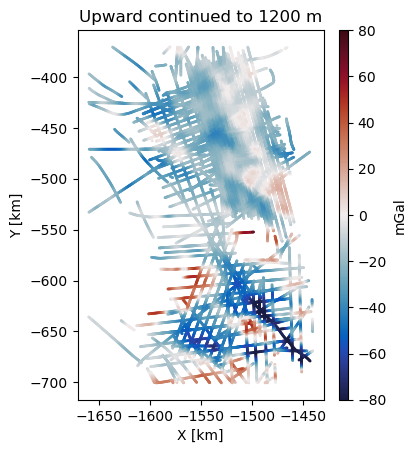

In [10]:
balance = cmocean.cm.balance

plt.scatter(grav.x/1000, grav.y/1000, c=leveled, s=1, vmin=-80, vmax=80, cmap=balance)
plt.axis('scaled')
plt.colorbar(pad=0.03, aspect=40, label='mGal')
plt.title(f'Upward continued to {height} m')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.show()

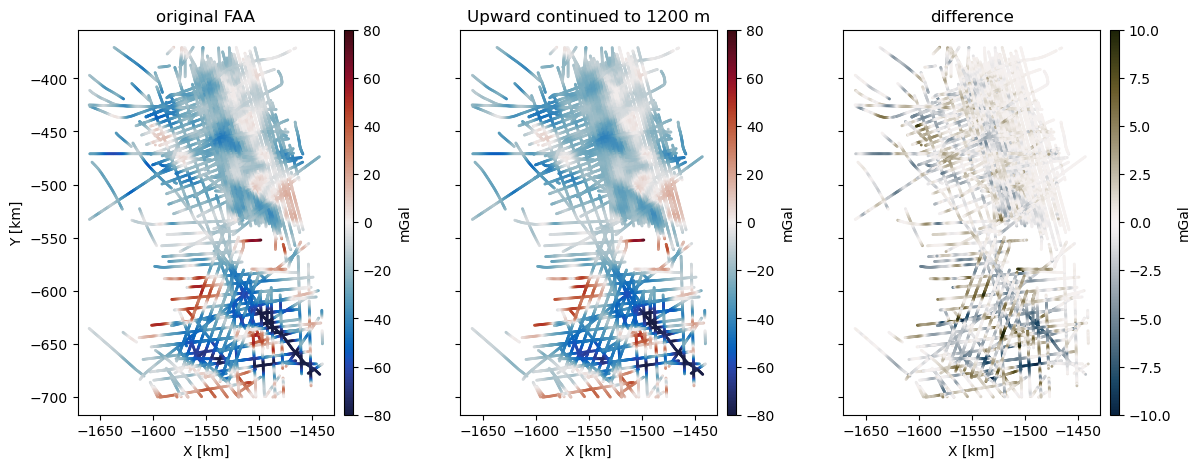

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(14,5), sharey=True)

ax = axs[0]
im = ax.scatter(grav.x/1000, grav.y/1000, c=grav.faa, s=1, vmin=-80, vmax=80, cmap=balance)
ax.axis('scaled')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='mGal')
ax.set_title(f'original FAA')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')

ax = axs[1]
im = ax.scatter(grav.x/1000, grav.y/1000, c=leveled, s=1, vmin=-80, vmax=80, cmap=balance)
ax.axis('scaled')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='mGal')
ax.set_title(f'Upward continued to {height} m')
ax.set_xlabel('X [km]')

ax = axs[2]
im = ax.scatter(grav.x/1000, grav.y/1000, c=grav.faa-leveled, s=1, vmin=-10, vmax=10, cmap=cmocean.cm.diff)
ax.axis('scaled')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='mGal')
ax.set_title(f'difference')
ax.set_xlabel('X [km]')

plt.show()

## Interpolate onto BedMachine grid

In [12]:
xx, yy = np.meshgrid(ds.x, ds.y)
pred_coords = (xx, yy, np.full(xx.shape, height))

leveled_grid = equivalent_sources.predict(pred_coords)

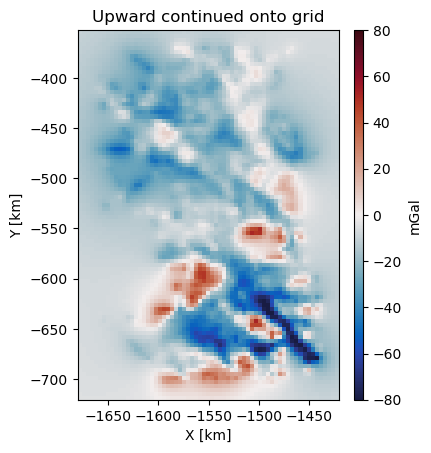

In [13]:
plt.pcolormesh(ds.x/1000, ds.y/1000, leveled_grid, vmin=-80, vmax=80, cmap=balance)
plt.axis('scaled')
plt.title('Upward continued onto grid')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.colorbar(pad=0.03, aspect=40, label='mGal')
plt.show()

## Apply distance mask to keep gridded values near sources

In [14]:
dist_msk = vd.distance_mask(coordinates[:2], 4000, pred_coords[:2])
leveled_mask = np.where(dist_msk, leveled_grid, np.nan)

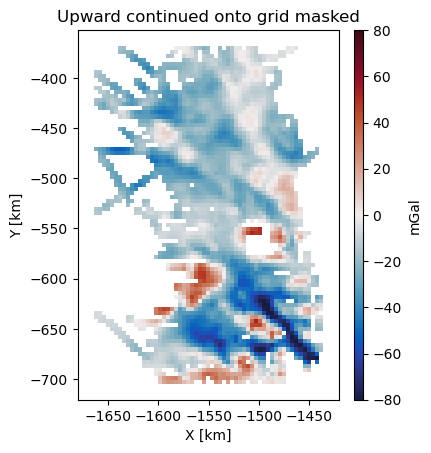

In [15]:
plt.pcolormesh(ds.x/1000, ds.y/1000, leveled_mask, vmin=-80, vmax=80, cmap=balance)
plt.axis('scaled')
plt.title('Upward continued onto grid masked')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.colorbar(pad=0.03, aspect=40, label='mGal')
plt.show()

# Make a function to do the whole process with good damping and depth parameters

You can modify this function to test with your dataset. The function

* trims the gravity data to the specified height
* upward continues the gravity data
* applies a distance mask with the specified maxdist

In [16]:
def upward_continue(grav, height, ds, maxdist):
    xx, yy = np.meshgrid(ds.x, ds.y)
    pred_coords = (xx, yy, np.full(xx.shape, height))
    grav_tmp = grav[grav.height < height]
    equivalent_sources = hm.EquivalentSourcesGB(damping=1, depth=3000, window_size=20e3)
    coordinates = (grav_tmp.x.values, grav_tmp.y.values, grav_tmp.height.values)
    equivalent_sources.fit(coordinates, grav_tmp.faa.values)
    leveled = equivalent_sources.predict(pred_coords)

    dist_msk = vd.distance_mask(coordinates[:2], maxdist, pred_coords[:2])
    masked = np.where(dist_msk, leveled, np.nan)

    return masked

In [17]:
grav2 = pd.read_csv(Path('processed_data/gravity_thwaites.csv'))
grav2 = grav2.loc[::10,:]

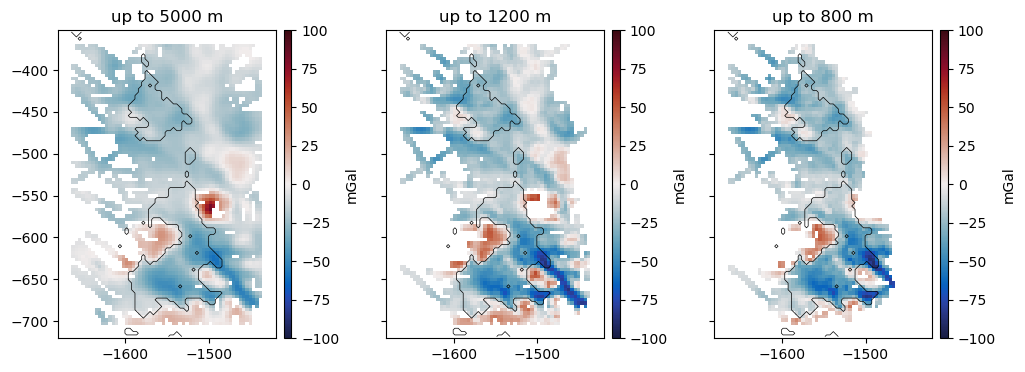

In [20]:
heights = [5000, 1200, 800]

fig, axs = plt.subplots(1, 3, figsize=(12,4), sharey=True)

for ax, h in zip(axs, heights):
    
    leveled_i = upward_continue(grav2, h, ds, 4000)
    
    im = ax.pcolormesh(xx/1000, yy/1000, leveled_i, vmin=-100, vmax=100, cmap=balance)
    ax.contour(ds.x/1000, ds.y/1000, ds.mask==3, levels=[0.5], colors='k', linewidths=0.5)
    ax.axis('scaled')
    ax.set_title(f'up to {h} m')
    plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='mGal')

plt.show()